In [1]:
import mysql.connector as mariadb
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Cap1.com').getOrCreate()

Spark libraries imported and session created.

In [2]:
df_branch = spark.read.json("credit_card_dataset\cdw_sapp_branch.json")
df_credit = spark.read.json("credit_card_dataset\cdw_sapp_credit.json")
df_customer = spark.read.json("credit_card_dataset\cdw_sapp_custmer.json")

In [35]:
df_branch.printSchema

<bound method DataFrame.printSchema of DataFrame[BRANCH_CITY: string, BRANCH_CODE: bigint, BRANCH_NAME: string, BRANCH_PHONE: string, BRANCH_STATE: string, BRANCH_STREET: string, BRANCH_ZIP: bigint, LAST_UPDATED: string]>

In [36]:
df_credit.printSchema

<bound method DataFrame.printSchema of DataFrame[BRANCH_CODE: bigint, CREDIT_CARD_NO: string, CUST_SSN: bigint, DAY: bigint, MONTH: bigint, TRANSACTION_ID: bigint, TRANSACTION_TYPE: string, TRANSACTION_VALUE: double, YEAR: bigint]>

In [10]:
df_customer.printSchema

<bound method DataFrame.printSchema of DataFrame[APT_NO: string, CREDIT_CARD_NO: string, CUST_CITY: string, CUST_COUNTRY: string, CUST_EMAIL: string, CUST_PHONE: bigint, CUST_STATE: string, CUST_ZIP: string, FIRST_NAME: string, LAST_NAME: string, LAST_UPDATED: string, MIDDLE_NAME: string, SSN: bigint, STREET_NAME: string]>

Now connecting to MariaDB and creating the database with 3 tables.

In [14]:
con = mariadb.connect(
    host = "xxxxxxxx",
    user = "xxxxxxxx",
    password = "xxxxxxxx",
)
print("connecting to MariaDB...")
cur = con.cursor()
st = "CREATE DATABASE creditcard_capstone"
cur.execute(st)
print("creditcard_capstone database created")
con.close()

connecting to MariaDB...
creditcard_capstone database created


In [5]:
df_branch.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_BRANCH") \
  .option("user", "x") \
  .option("password", "x") \
  .save()

df_credit.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_CREDIT_CARD") \
  .option("user", "x") \
  .option("password", "x") \
  .save()

#move username and password into a new module so people cannot access it...

df_customer.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_CUSTOMER") \
  .option("user", "x") \
  .option("password", "x") \
  .save()

In [3]:
df_branch.createTempView("branch")
df_credit.createTempView("credit")
df_customer.createTempView("customer")

In [4]:
spark.sql("SELECT * from branch").show(10)

+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|      BRANCH_CITY|BRANCH_CODE| BRANCH_NAME|BRANCH_PHONE|BRANCH_STATE|    BRANCH_STREET|BRANCH_ZIP|        LAST_UPDATED|
+-----------------+-----------+------------+------------+------------+-----------------+----------+--------------------+
|        Lakeville|          1|Example Bank|  1234565276|          MN|     Bridle Court|     55044|2018-04-18T16:51:...|
|          Huntley|          2|Example Bank|  1234618993|          IL|Washington Street|     60142|2018-04-18T16:51:...|
|SouthRichmondHill|          3|Example Bank|  1234985926|          NY|    Warren Street|     11419|2018-04-18T16:51:...|
|       Middleburg|          4|Example Bank|  1234663064|          FL| Cleveland Street|     32068|2018-04-18T16:51:...|
|    KingOfPrussia|          5|Example Bank|  1234849701|          PA|      14th Street|     19406|2018-04-18T16:51:...|
|         Paterson|          7|E

In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot

In [6]:
df_cred_pd = df_credit.toPandas()

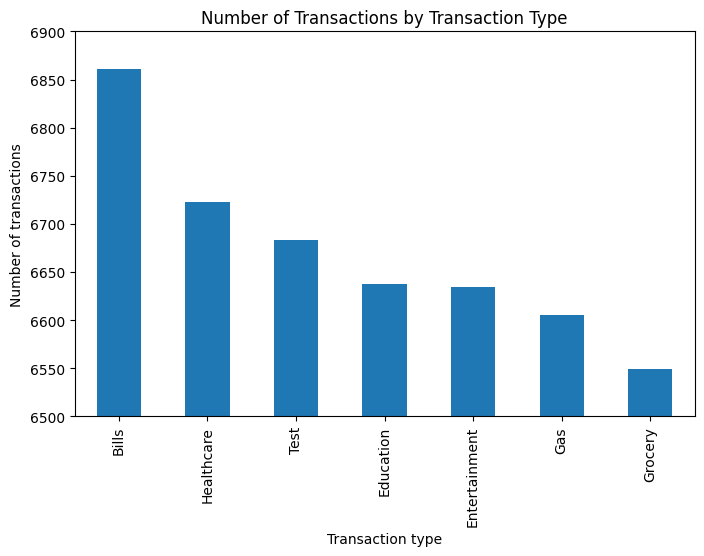

In [7]:
df_cred_pd['TRANSACTION_TYPE'].value_counts().plot(kind='bar', figsize=(8, 5))
#on a graph that starts at 0, it is hard to see much difference in counts on the y axis for these types, so 
#this graph has the limits placed on the y axis which will frame the values in a clearer way.
pyplot.ylim(6500,6900)
pyplot.title('Number of Transactions by Transaction Type')
pyplot.ylabel('Number of transactions')
pyplot.xlabel('Transaction type')
pyplot.show()

In [8]:
df_cust_pd = df_customer.toPandas()

In [40]:
df_cust_pd['CUST_STATE'].value_counts()

NY    96
GA    73
PA    72
FL    64
IL    58
NJ    53
MD    50
CA    45
OH    44
MI    44
VA    39
NC    37
TX    33
MA    33
SC    30
WI    29
MN    28
MS    24
IA    21
KY    17
WA    16
CT    14
IN    13
MT     9
AR     5
AL     5
Name: CUST_STATE, dtype: int64

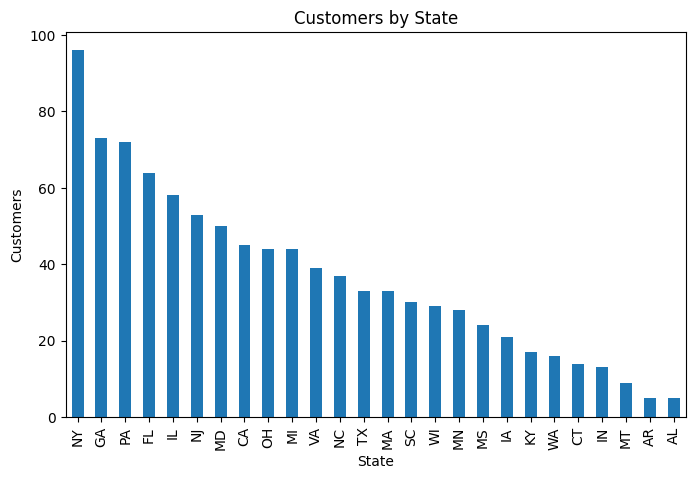

In [9]:
df_cust_pd['CUST_STATE'].value_counts().plot(kind='bar', figsize=(8, 5))

pyplot.title('Customers by State')
pyplot.ylabel('Customers')
pyplot.xlabel('State')
pyplot.show()

Try this with Spark SQL too, since it could mean either thing (group by SSN)...and/but also can try to figure out other stats models to use. 

In [10]:
spark.sql("SELECT CUST_STATE, COUNT(DISTINCT SSN) AS TOTAL_CUSTOMERS \
            FROM customer GROUP BY CUST_STATE ORDER BY TOTAL_CUSTOMERS DESC").show() 

+----------+---------------+
|CUST_STATE|TOTAL_CUSTOMERS|
+----------+---------------+
|        NY|             96|
|        GA|             73|
|        PA|             72|
|        FL|             64|
|        IL|             58|
|        NJ|             53|
|        MD|             50|
|        CA|             45|
|        MI|             44|
|        OH|             44|
|        VA|             39|
|        NC|             37|
|        TX|             33|
|        MA|             33|
|        SC|             30|
|        WI|             29|
|        MN|             28|
|        MS|             24|
|        IA|             21|
|        KY|             17|
+----------+---------------+
only showing top 20 rows



In [11]:
df_cust_state = spark.sql("SELECT CUST_STATE, COUNT(DISTINCT SSN) AS TOTAL_CUSTOMERS \
            FROM customer GROUP BY CUST_STATE ORDER BY TOTAL_CUSTOMERS DESC").toPandas()
df_cust_state.head()

,CUST_STATE,TOTAL_CUSTOMERS
0,NY,96
1,GA,73
2,PA,72
3,FL,64
4,IL,58


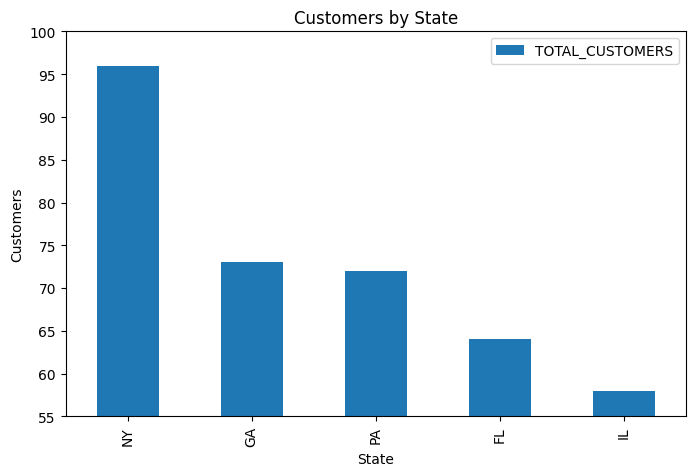

In [12]:
df_cust_state.head().plot(kind='bar', x = 'CUST_STATE', y = 'TOTAL_CUSTOMERS', figsize=(8, 5))

pyplot.title('Customers by State')
pyplot.ylabel('Customers')
pyplot.xlabel('State')
pyplot.ylim(55,100)

pyplot.show()

The next one should definitely use SQL.
Functional Requirements 3.3
Find and plot the sum of all transactions for each customer, and which customer has the highest transaction amount.
hint(use CUST_SSN).

---this also has a double meaning, so may as well do both meanings.

In [13]:
df_cust_val = spark.sql("SELECT CUST_SSN, SUM(TRANSACTION_VALUE) AS TOTAL_VALUE \
            FROM credit GROUP BY CUST_SSN ORDER BY TOTAL_VALUE DESC") 

In [14]:
df_cust_val = df_cust_val.toPandas()

In [14]:
df_cust_val.head(10)

,CUST_SSN,TOTAL_VALUE
0,123451125,5633.07
1,123452783,5548.14
2,123453486,5476.08
3,123458668,5314.97
4,123456678,5261.03
5,123452026,5241.18
6,123452518,5223.96
7,123454933,5203.08
8,123457547,5149.75
9,123452085,5133.29


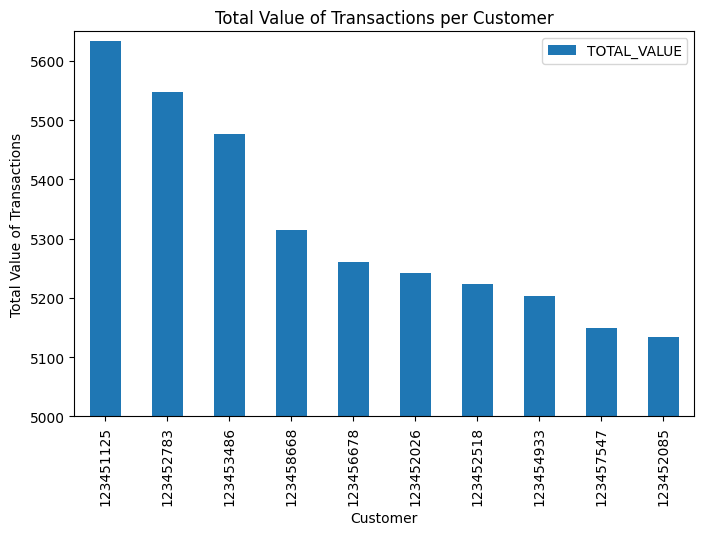

In [15]:
#df_cust_val.reset_index(inplace=True)
df_cust_val.head(10).plot(kind='bar', x='CUST_SSN', y='TOTAL_VALUE',  figsize=(8, 5))

pyplot.title('Total Value of Transactions per Customer')

pyplot.ylabel('Total Value of Transactions')

pyplot.xlabel('Customer')
pyplot.ylim(5000,5650)

pyplot.show()

In [6]:
spark.sql("SELECT CUST_SSN, COUNT(*) AS TOTAL_TRANSACTIONS \
            FROM credit GROUP BY CUST_SSN ORDER BY TOTAL_TRANSACTIONS DESC").show() 

+---------+------------------+
| CUST_SSN|TOTAL_TRANSACTIONS|
+---------+------------------+
|123453831|                99|
|123456678|                99|
|123451701|                99|
|123457070|                99|
|123458668|                99|
|123451357|                99|
|123456557|                98|
|123456849|                98|
|123458993|                98|
|123458645|                98|
|123452890|                98|
|123459441|                98|
|123455898|                98|
|123452026|                98|
|123451173|                98|
|123456862|                98|
|123458265|                98|
|123452783|                97|
|123457278|                97|
|123459723|                97|
+---------+------------------+
only showing top 20 rows



PART 4

In [16]:
import mysql.connector as mariadb
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Cap4.com').getOrCreate()
import requests
import json

In [17]:
url = 'https://raw.githubusercontent.com/platformps/LoanDataset/main/loan_data.json'
response = requests.get(url)

In [18]:
response

<Response [200]>

In [19]:
cdw_sapp_loan4 = response.json()

In [20]:
df_loan = spark.createDataFrame(cdw_sapp_loan4)
df_loan_quantum = spark.createDataFrame(cdw_sapp_loan4)

In [31]:
with open('cdw_sapp_loan4.json', 'w') as out_file:
     json.dump(cdw_sapp_loan4, out_file) 


In [21]:
df_loan_q2 = spark.read.json("cdw_sapp_loan4.json")

In [15]:
df_loan.show()

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001002|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001008|                 Y|             1|         0|    Graduate|  Male|medium|     No|        Urban|           No|


In [5]:
df_loan.printSchema()

root
 |-- Application_ID: string (nullable = true)
 |-- Application_Status: string (nullable = true)
 |-- Credit_History: long (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- Self_Employed: string (nullable = true)



In [ ]:
df_loan_q2.write.format("jdbc") \
  .mode("append") \
  .option("url", "jdbc:mysql://localhost:3306/creditcard_capstone") \
  .option("dbtable", "CDW_SAPP_loan_application_q3") \
  .option("user", "x") \
  .option("password", "x") \
  .save()

In [22]:
df_loan_se = df_loan.where(df_loan.Self_Employed == 'Yes')
df_loan_se.show()

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001011|                 Y|             1|         2|    Graduate|  Male|medium|    Yes|        Urban|          Yes|
|      LP001066|                 Y|             1|         0|    Graduate|  Male|medium|    Yes|    Semiurban|          Yes|
|      LP001097|                 N|             1|         1|    Graduate|  Male|medium|     No|        Rural|          Yes|
|      LP001136|                 Y|             1|         0|Not Graduate|  Male|medium|    Yes|        Urban|          Yes|


In [23]:
df_loan_se.createOrReplaceTempView('self_employed')


In [24]:
spark.sql("select count(*) from self_employed").show()

+--------+
|count(1)|
+--------+
|      70|
+--------+



In [19]:
spark.sql("select count(*) from self_employed WHERE Application_Status == 'Y'").show()

+--------+
|count(1)|
+--------+
|      46|
+--------+



In [25]:
percent = round((46/70)*100,2)
print(f"The percentage of applications approved for self-employed applicants is {percent}%.")

The percentage of applications approved for self-employed applicants is 65.71%.


In [26]:
df_loan_sepd = df_loan_se.toPandas()

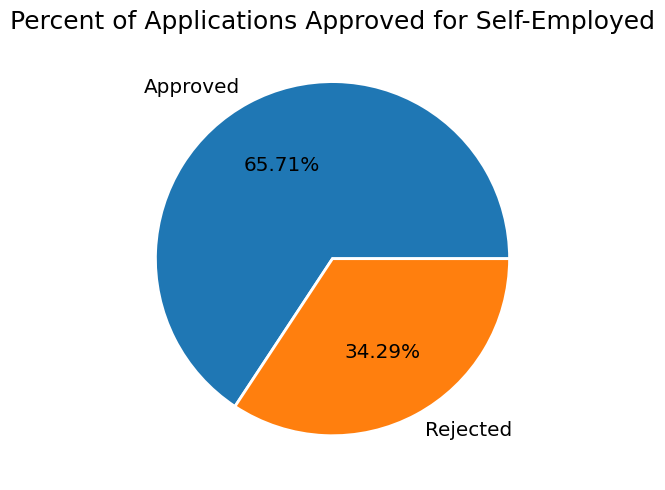

In [27]:
#df_cust_val.reset_index(inplace=True)
x = df_loan_sepd['Application_Status'].value_counts()
fig, ax = pyplot.subplots(figsize=(8, 5))
labels = ['Approved','Rejected']
ax.pie(x, labels=labels, autopct='%.2f%%',
       wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})
ax.set_title('Percent of Applications Approved for Self-Employed', fontsize=18)
pyplot.tight_layout()

pyplot.show()


In [28]:
df_loan_m = df_loan.where(df_loan.Married == 'Yes')
df_loan_mm = df_loan_m.where(df_loan_m.Gender == 'Male')
df_loan_mm.show()

+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|Application_ID|Application_Status|Credit_History|Dependents|   Education|Gender|Income|Married|Property_Area|Self_Employed|
+--------------+------------------+--------------+----------+------------+------+------+-------+-------------+-------------+
|      LP001003|                 N|             1|         1|    Graduate|  Male|medium|    Yes|        Rural|           No|
|      LP001005|                 Y|             1|         0|    Graduate|  Male|   low|    Yes|        Urban|          Yes|
|      LP001006|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|
|      LP001011|                 Y|             1|         2|    Graduate|  Male|medium|    Yes|        Urban|          Yes|
|      LP001013|                 Y|             1|         0|Not Graduate|  Male|   low|    Yes|        Urban|           No|


In [29]:
df_loan_mm.createOrReplaceTempView('married_men')
spark.sql("select count(*) from married_men").show()

+--------+
|count(1)|
+--------+
|     306|
+--------+



In [25]:
spark.sql("select count(*) from married_men WHERE Application_Status == 'N'").show()

+--------+
|count(1)|
+--------+
|      87|
+--------+



In [26]:
percent = round((87/306)*100,2)
print(f"The percentage of applications rejected for married male applicants is {percent}%.")

The percentage of applications rejected for married male applicants is 28.43%.


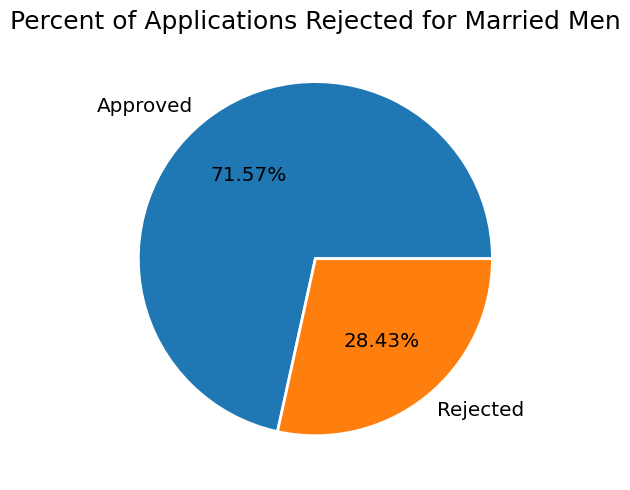

In [30]:
df_loan_mmpd = df_loan_mm.toPandas()
x = df_loan_mmpd['Application_Status'].value_counts()

fig, ax = pyplot.subplots(figsize=(8, 5))
labels = ['Approved','Rejected']
ax.pie(x, labels=labels, autopct='%.2f%%',
       wedgeprops={'linewidth': 2.0, 'edgecolor': 'white'},
       textprops={'size': 'x-large'})
ax.set_title('Percent of Applications Rejected for Married Men', fontsize=18)
pyplot.tight_layout()

pyplot.show()

Functional Requirements 5.3
Find and plot the top three months with the largest transaction data.
Note: Take a screenshot of the graph. 
LARGEST NUMBER? OR LARGEST TOTAL VALUE? BOTH?

In [88]:
df_month_num = spark.sql("SELECT MONTH, COUNT(TRANSACTION_ID) AS TRANSACTIONS FROM credit \
            GROUP BY MONTH ORDER BY TRANSACTIONS DESC LIMIT 3").toPandas()
df_month_num.head()

,MONTH,TRANSACTIONS
0,2,3959
1,5,3946
2,10,3946


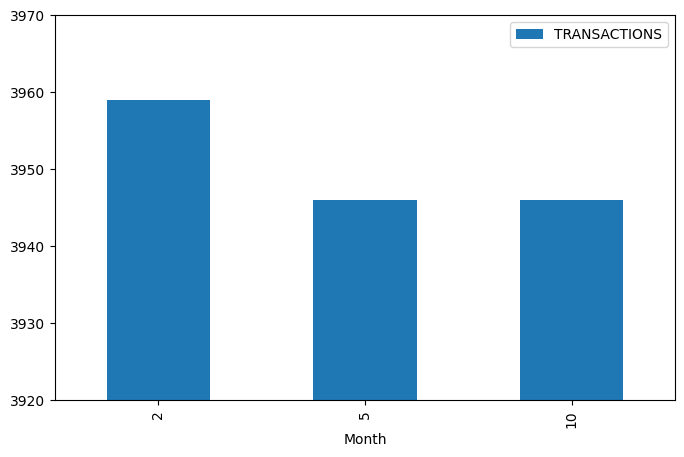

In [89]:

#df_month.set_index(['MONTH'])
df_month_num.plot(kind = "bar", x = 'MONTH', y = 'TRANSACTIONS', figsize = (8,5))
pyplot.ylim(3920,3970)
pyplot.xlabel('Month')
pyplot.show()

In [71]:
df_month = spark.sql("SELECT MONTH, SUM(TRANSACTION_VALUE) AS TRANSACTION_SUM FROM credit \
            GROUP BY MONTH ORDER BY TRANSACTION_SUM DESC LIMIT 3").toPandas()

In [72]:
df_month.head()

,MONTH,TRANSACTION_SUM
0,10,202583.89
1,5,201310.26
2,12,201251.08


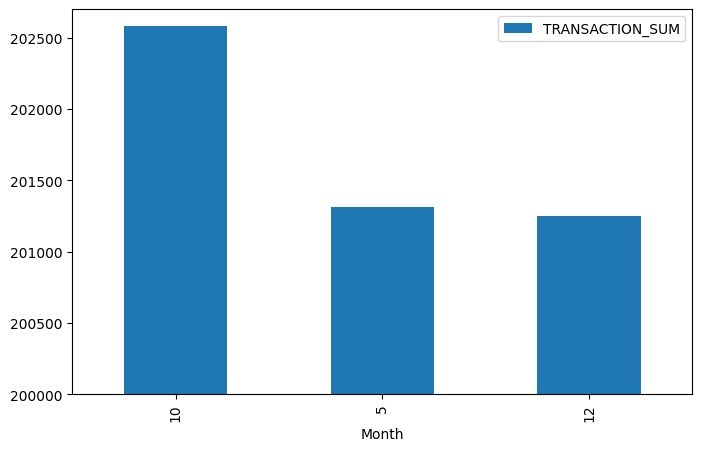

In [81]:

#df_month.set_index(['MONTH'])
df_month.plot(kind = "bar", x = 'MONTH', y = 'TRANSACTION_SUM', figsize = (8,5))
pyplot.ylim(200000,202700)
pyplot.xlabel('Month')
pyplot.show()

In [91]:
df_healthc = spark.sql("SELECT BRANCH_CODE, SUM(TRANSACTION_VALUE) AS TRANSACTION_SUM \
                FROM credit GROUP BY BRANCH_CODE ORDER BY TRANSACTION_SUM DESC LIMIT 5").toPandas()
df_healthc.head()


,BRANCH_CODE,TRANSACTION_SUM
0,70,23792.89
1,79,23641.99
2,46,23507.66
3,45,23350.68
4,37,22991.33


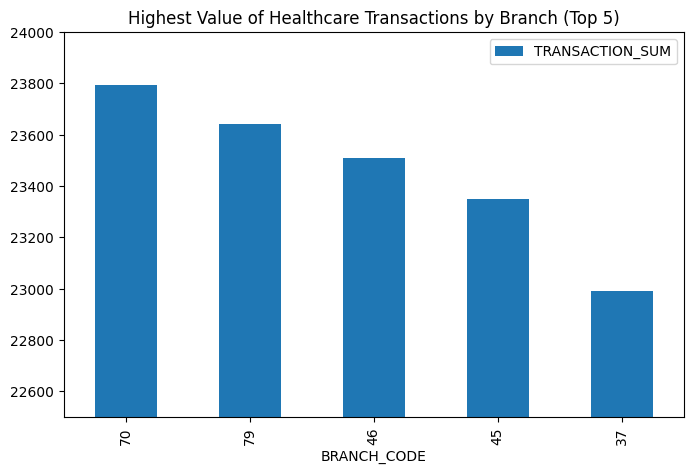

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 64919)
Traceback (most recent call last):
  File "C:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Users\jerem\AppData\Local\Programs\Python\Python310\lib\socketserver.py", line 747, in __init__
    self.handle()
  File "c:\Users\jerem\Per_scholas_python_practice\capstone_work\lib\site-packages\pyspark\accumulators.py", line 281, in handle
    poll(accum_updates)
  File "c:\Users\jerem\Per_scholas_python_practice\capstone_work

In [94]:
df_healthc.plot(kind='bar', x='BRANCH_CODE', y='TRANSACTION_SUM',  figsize=(8, 5))

# add a title to the histogram
pyplot.title('Highest Value of Healthcare Transactions by Branch (Top 5)')
# add y-label
pyplot.ylim(22500,24000)

pyplot.show()